In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import PIL
import shutil

drive.mount('/content/drive', force_remount = True)

base_dir = '/content/drive/MyDrive/Colab Notebooks/Building_Model'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir,'test')

train_1_dir = os.path.join(train_dir, '1')
train_6_dir = os.path.join(train_dir, '6')
train_7_dir = os.path.join(train_dir, '7')

validation_1_dir = os.path.join(validation_dir, '1')
validation_6_dir = os.path.join(validation_dir, '6')
validation_7_dir = os.path.join(validation_dir, '7')

test_1_dir = os.path.join(test_dir, '1')
test_6_dir = os.path.join(test_dir, '6')
test_7_dir = os.path.join(test_dir, '7')

Mounted at /content/drive


In [ ]:
import torch


torch.tensor(7).shape

torch.Size([])

In [ ]:
torch.tensor(7).shape

torch.Size([])

In [ ]:
# 각 폴더에 jpg파일 몇개씩있는지 확인하는 코드
print('Total training 1 images : ', len(os.listdir(train_1_dir)))
print('Total training 6 images : ', len(os.listdir(train_6_dir)))
print('Total training 7 images : ', len(os.listdir(train_7_dir)))
print('')

print('Total validation 1 images : ', len(os.listdir(validation_1_dir)))
print('Total validation 6 images : ', len(os.listdir(validation_6_dir)))
print('Total validation 7 images : ', len(os.listdir(validation_7_dir)))
print('')

print('Total test 1 images : ', len(os.listdir(test_1_dir)))
print('Total test 6 images : ', len(os.listdir(test_6_dir)))
print('Total test 7 images : ', len(os.listdir(test_7_dir)))

Total training 1 images :  164
Total training 6 images :  165
Total training 7 images :  133

Total validation 1 images :  106
Total validation 6 images :  77
Total validation 7 images :  76

Total test 1 images :  4
Total test 6 images :  4
Total test 7 images :  4


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train 이미지 부풀리기
train_datagen = ImageDataGenerator(
    rescale = 1.0 / 255,
    rotation_range = 15,            # 이미지를 15도 이내로 회전
    width_shift_range = 0.05,       # 좌우로 5% 이동
    height_shift_range = 0.05,      # 상하로 5% 이동
    zoom_range = 0.2,               # 최대 20% 확대/축소
    horizontal_flip = True,         # 좌우 반전
    vertical_flip = True,            # 상하 반전
    fill_mode = 'nearest'           # 기본값으로 주변 픽셀 값으로 공백을 채움
)

validation_datagen = ImageDataGenerator(rescale = 1.0 / 255) # 검증 데이터는 rescale만 적용
test_datagen = ImageDataGenerator(rescale = 1.0 / 255) # 테스트 데이터는 rescale만 적용

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 8,
    class_mode = 'categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size = 4,
    class_mode = 'categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150,150),
    batch_size = 1,
    class_mode = 'categorical'
)

train_generator.class_indices

Found 462 images belonging to 3 classes.
Found 259 images belonging to 3 classes.
Found 12 images belonging to 3 classes.


{'1': 0, '6': 1, '7': 2}

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
history = model.fit_generator(
    train_generator, # train_generator안에 X값, y값 다 있으니 generator만 주면 된다
    steps_per_epoch = 20, # 한 번의 에포크(epoch)에서 훈련에 사용할 배치(batch)의 개수 지정; generator를 12번 부르겠다
    epochs = 100, # 데이터셋을 한 번 훈련하는 과정; epoch은 100 이상은 줘야한다
    validation_data = validation_generator, # validation_generator안에도 검증용 x,y데이터들이 다 있으니 generator로 주면 됨
    validation_steps = 10, # 한 번의 에포크가 끝날 때, 검증에 사용되는 배치(batch)의 개수를 지정; validation_generator를 10번 불러서 나온 이미지들로 작업을 해라
    verbose = 2
)

<ipython-input-7-ec77ad54e878>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
20/20 - 59s - loss: 1.1627 - accuracy: 0.3291 - val_loss: 1.0968 - val_accuracy: 0.4250 - 59s/epoch - 3s/step
Epoch 2/100
20/20 - 53s - loss: 1.0907 - accuracy: 0.4500 - val_loss: 1.0445 - val_accuracy: 0.4500 - 53s/epoch - 3s/step
Epoch 3/100
20/20 - 33s - loss: 1.0187 - accuracy: 0.4625 - val_loss: 0.9752 - val_accuracy: 0.4500 - 33s/epoch - 2s/step
Epoch 4/100
20/20 - 30s - loss: 0.8593 - accuracy: 0.5633 - val_loss: 0.7077 - val_accuracy: 0.5750 - 30s/epoch - 1s/step
Epoch 5/100
20/20 - 27s - loss: 0.6838 - accuracy: 0.6013 - val_loss: 0.7446 - val_accuracy: 0.5250 - 27s/epoch - 1s/step
Epoch 6/100
20/20 - 24s - loss: 0.5774 - accuracy: 0.7215 - val_loss: 0.5585 - val_accuracy: 0.6750 - 24s/epoch - 1s/step
Epoch 7/100
20/20 - 38s - loss: 0.6743 - accuracy: 0.5759 - val_loss: 0.7306 - val_accuracy: 0.6500 - 38s/epoch - 2s/step
Epoch 8/100
20/20 - 22s - loss: 0.5985 - accuracy: 0.7152 - val_loss: 0.5266 - val_accuracy: 0.7500 - 22s/epoch - 1s/step
Epoch 9/100
20/20 - 21s 

In [ ]:
from keras.models import load_model
model.save('/content/drive/MyDrive/Colab Notebooks/newBuilding_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
model_saveFile = load_model('/content/drive/MyDrive/Colab Notebooks/newBuilding_model.h5')

In [ ]:
model_saveFile.evaluate(train_generator) #학습모델의 train 데이터 정확도 보기
model_saveFile.evaluate(validation_generator) #학습모델의 validation정확도 보기

65/65 [==============================] - 11s 174ms/step - loss: 0.9198 - accuracy: 0.7722


[0.9197964072227478, 0.7722007632255554]

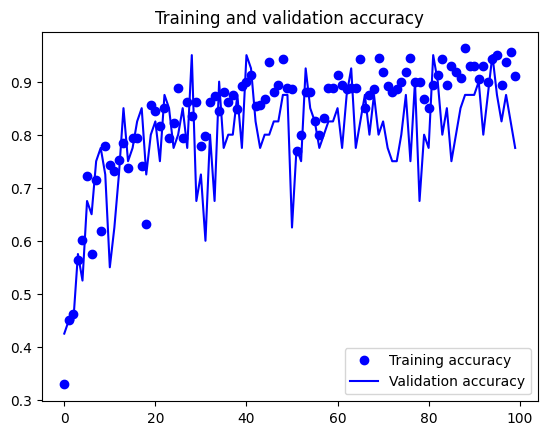

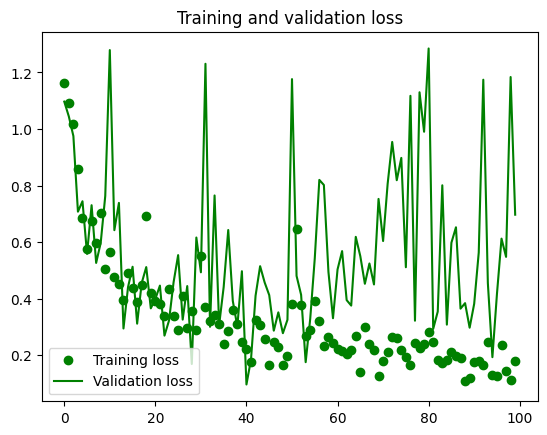

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

1/1 [==============================] - 0s 211ms/step


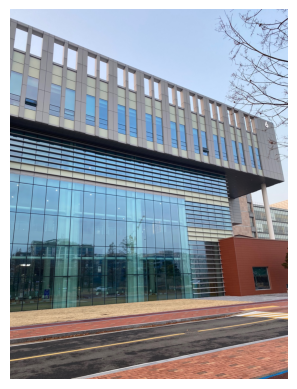

위 사진은 6 으로 판명되었습니다


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 모델을 저장한 경로에 따라 수정해주세요.
model_path = '/content/drive/MyDrive/Colab Notebooks/newBuilding_model.h5'

# 저장된 모델 불러오기
loaded_model = load_model(model_path)

# 테스트 이미지 경로
test_image_path = '/content/drive/MyDrive/Colab Notebooks/Building_Model/test/6/KakaoTalk_20240114_173159780_06.jpg'

# 이미지를 모델의 입력 크기에 맞게 로드
img = image.load_img(test_image_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # 모델 입력에 맞게 차원 확장

# 이미지 정규화
img_array /= 255.0

# 예측 수행
predictions = loaded_model.predict(img_array)

# 클래스 인덱스 가져오기
class_index = np.argmax(predictions[0])

# 클래스 레이블 매핑
class_mapping = {'0': '1', '1': '6', '2': '7'}
predicted_class = class_mapping[str(class_index)]

# 이미지 플로팅
img = mpimg.imread(test_image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

print(f"위 사진은 {predicted_class} 으로 판명되었습니다")


1/1 [==============================] - 0s 70ms/step


IndexError: index 12 is out of bounds for axis 0 with size 12

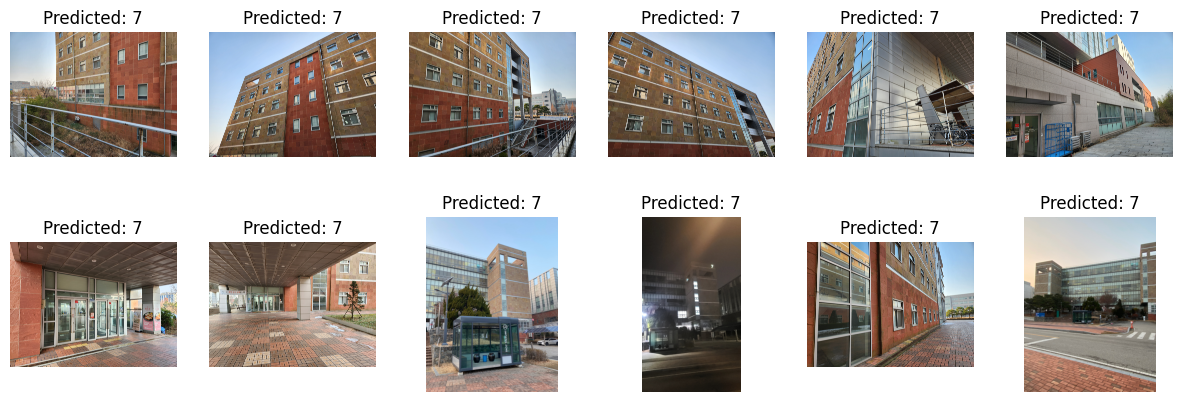

In [ ]:
import os


test_directory = '/content/drive/MyDrive/Colab Notebooks/Building_Model/validation/7'


fig, axs = plt.subplots(2, 6, figsize=(15, 5))
axs = axs.ravel()


for i, filename in enumerate(os.listdir(test_directory)):
    if filename.endswith(".jpg") and  i<42:

        test_image_path = os.path.join(test_directory, filename)

        #
        img = image.load_img(test_image_path, target_size=(150, 150))
        img_array = image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        img_array /= 255.0


        predictions = loaded_model.predict(img_array)
        class_index = np.argmax(predictions[0])


        if class_index == 0:
            predicted_class = '6'
        else:
            predicted_class = '7'


        axs[i].imshow(mpimg.imread(test_image_path))
        axs[i].axis('off')
        axs[i].set_title(f"Predicted: {predicted_class}")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()